In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
import acquisition_function as acqf
import discrete_mes as mes
import discrete_ucb as ucb
import discrete_ei as ei
import discrete_pi as pi
import itertools

from dimension import Real,Integer, Categorical,Dimension

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# agrmax(target) = 2
def target(x):
    return -1*(3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1) +torch.randn(x.size()) * .1)

func = lambda x: -1*target(x)
    
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6))
# True function with Gaussian noise N(0,0.01)
train_y = Variable(-1*target(train_x))

#true target (unknown)
x = torch.linspace(-5, 15, 1000)
y = target(x)
torch.is_tensor(x)

True

In [3]:
y.mean(0)

tensor(-0.9078)

In [3]:
'''
#inclusive sampling
class Space():
    def __init__(self):
        self.candidate_set = None
    @property
    def get_samples(self):
        return self.candidate_set
class Real(Space):
    def __init__(self, lower, upper, sampling ="linear",steps=1000):
        if upper <= lower:
            raise ValueError("the lower bound {} has to be less than the"
                             " upper bound {}".format(lower, upper))
        super(Real,self).__init__()
        if sampling == "linear":
            self.candidate_set = torch.linspace(lower, upper, steps)
        elif sampling == "log_uniform":
            self.candidate_set = torch.logspace(lower, upper, steps)
        else:
            raise ValueError("Sampling can only handle linear or log_uniform")
    
class Integer(Space):
    def __init__(self, lower, upper):
        if upper <= lower:
            raise ValueError("the lower bound {} has to be less than the"
                             " upper bound {}".format(lower, upper))
        super(Integer,self).__init__()
        self.candidate_set = torch.range(lower, upper)
        

class Categorical(Space):
    def __init__(self,space):
        if len(space) < 1:
            raise ValueError("the number of class has to be greater than 0")
        super(Categorical,self).__init__()
        self.candidate_set = torch.Tensor(space)

class Dimension():
    def __init__(self, dimensions):
        if dimensions is None:
            raise ValueError("dimensions can't be none")
        self.candidate_set =[]
        D =[]
        for dimension in dimensions:
            D.append(dimension.get_samples)
        for e in itertools.product(*D):
            e = torch.stack(e)
            self.candidate_set.append(e)
        self.candidate_set = torch.stack(self.candidate_set)
    
    @property
    def get_samples(self):
        return self.candidate_set
'''

'\n#inclusive sampling\nclass Space():\n    def __init__(self):\n        self.candidate_set = None\n    @property\n    def get_samples(self):\n        return self.candidate_set\nclass Real(Space):\n    def __init__(self, lower, upper, sampling ="linear",steps=1000):\n        if upper <= lower:\n            raise ValueError("the lower bound {} has to be less than the"\n                             " upper bound {}".format(lower, upper))\n        super(Real,self).__init__()\n        if sampling == "linear":\n            self.candidate_set = torch.linspace(lower, upper, steps)\n        elif sampling == "log_uniform":\n            self.candidate_set = torch.logspace(lower, upper, steps)\n        else:\n            raise ValueError("Sampling can only handle linear or log_uniform")\n    \nclass Integer(Space):\n    def __init__(self, lower, upper):\n        if upper <= lower:\n            raise ValueError("the lower bound {} has to be less than the"\n                             " upper boun

In [4]:

dim = [Real(-1,1,steps=3),Integer(2,4),Categorical([7.5,8.5]),Categorical([-3,-5])]
search_space = Dimension(dim)
print(search_space.get_samples.size())


 

torch.Size([36, 4])


In [5]:
'''* `dimensions` [list, shape=(n_dims,)]:
        List of search space dimensions.
        Each search dimension can be defined either as
        - a `(lower_bound, upper_bound)` tuple (for `Real` or `Integer`
          dimensions),
        - a `(lower_bound, upper_bound, "prior")` tuple (for `Real`
          dimensions),
        - as a list of categories (for `Categorical` dimensions), or
        - an instance of a `Dimension` object (`Real`, `Integer` or
          `Categorical`).
'''

'* `dimensions` [list, shape=(n_dims,)]:\n        List of search space dimensions.\n        Each search dimension can be defined either as\n        - a `(lower_bound, upper_bound)` tuple (for `Real` or `Integer`\n          dimensions),\n        - a `(lower_bound, upper_bound, "prior")` tuple (for `Real`\n          dimensions),\n        - as a list of categories (for `Categorical` dimensions), or\n        - an instance of a `Dimension` object (`Real`, `Integer` or\n          `Categorical`).\n'

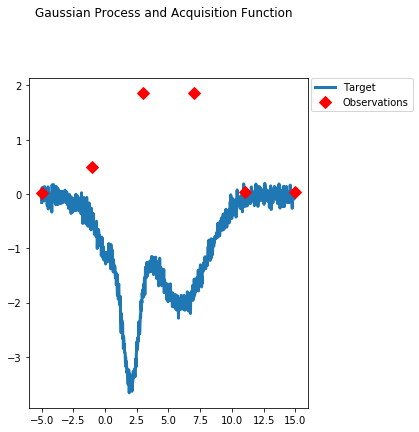

In [6]:
# plotting gp 
def plot_gp(train_x, train_y, x, y, rand_var=None, model=False, acq = None, bo=False):
    fig = plt.figure(figsize=(5,10))
    gs = gridspec.GridSpec(2,1,height_ratios=[2, 1]) 
    axis = plt.subplot(gs[0])
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(train_x, train_y, 'D', markersize=8, label=u'Observations', color='r')
    fig.suptitle('Gaussian Process and Acquisition Function',fontdict={'size':30})
    # if model is trained 
    if model == True:
        lower, upper = rand_var.confidence_region()
        mean = rand_var.mean().data.numpy()
        var = rand_var.var().data.numpy()
        axis.plot(x, mean, '--', color='k', label='Prediction')
       # axis.fill_between(x, lower.data.numpy(), upper.data.numpy(), alpha=.6, label='95% confidence interval')
        axis.fill_between(x, y - 1.96 * var , y + 1.96 * var, alpha=.3, label='95% confidence interval')
    
    # if acqusition function is available
    if bo == True:
        acqusition = plt.subplot(gs[1])
        acqusition.plot(x, acq.data.numpy(), label='Utility Function', color='purple')
        acqusition.plot(x[torch.argmax(acq)], torch.max(acq).data.numpy(), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
        acqusition.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    
# target function and observations 
plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), y.numpy())

In [7]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-5,15]
        self.mean_module = ConstantMean(constant_bounds=(-5,15))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return model output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [8]:
# train model to get the hypeparameters 
def train_model(model,train_x,train_y):   
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iter = 10
    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        '''
        print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
            i + 1, training_iter, loss.data[0],
            model.covar_module.log_lengthscale.data[0, 0],
            model.likelihood.log_noise.data[0]
        ))
        '''
        optimizer.step()


In [9]:
# predict
def eval_model(model,likelihood):   
    # Put model and likelihood into eval mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with gpytorch.fast_pred_var():
        observed_pred = likelihood(model(x))
    return observed_pred

In [10]:

#acquisition function using upper confidence bound 
def ucbi(observed_pred, kappa=5):
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    acq = mean + kappa * std
    return acq,torch.argmax(acq)

# expected improvement 
def eii(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = (mean - y_max) * Normal(0,1).cdf(z) + std * Normal(0,1).log_prob(z).exp()
    return acq, torch.argmax(acq)

# probability of improvement
def poi(observed_pred, train_y):
    y_max = torch.max(train_y)
    mean = observed_pred.mean()
    std = torch.sqrt(observed_pred.var())
    z = (mean - y_max) / std
    acq = Normal(0,1).cdf(z) 
    return acq, torch.argmax(acq)



# max value entropy search
def mesi(observed_pred):
    with gpytorch.beta_features.fast_pred_var(), gpytorch.beta_features.fast_pred_samples():
    
        f_samples = observed_pred.sample(100)
        y_star_sample = f_samples.max(dim=0)

        y_max = y_star_sample[0].repeat(1000,1).t()

        mean = observed_pred.mean()
        std = torch.sqrt(observed_pred.var())

        gamma = (y_max - mean ) / std
        acq =  gamma * Normal(0,1).log_prob(gamma).exp() / (2 *  Normal(0,1).cdf(gamma)) - torch.log(Normal(0,1).cdf(gamma))

        acq = acq.sum(dim =0) / 100
        index = torch.argmax(acq)

    return acq, index


train_x = Variable(torch.linspace(-5, 15, 6))
train_y = Variable(target(train_x))
train_inputs = (torch.ones(2),)
likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
model = ExactGPModel(train_x.data, train_y.data, likelihood)
t = torch.ones(2)
print(t)
print(t.ndimension())
print(t.unsqueeze(-1))
print(tuple(tri.unsqueeze(-1) if tri.ndimension() == 1 else tri for tri in train_inputs))
print(train_x.dtype)

next point tensor([[ 6.4915]])
next point tensor([[ 5.8709]])
next point tensor([[ 5.9309]])
next point tensor([[ 6.0511]])
next point tensor([[ 4.6096]])
next point tensor([[ 1.8268]])
next point tensor([[ 1.6066]])
next point tensor([[ 1.9670]])
next point tensor([[ 2.0671]])
next point tensor([[ 2.1271]])


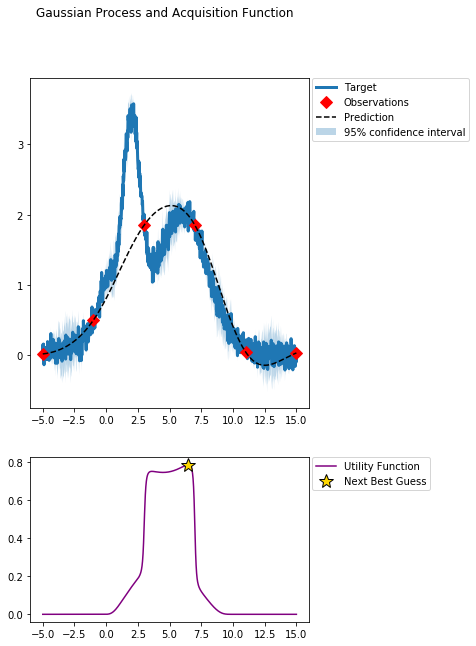

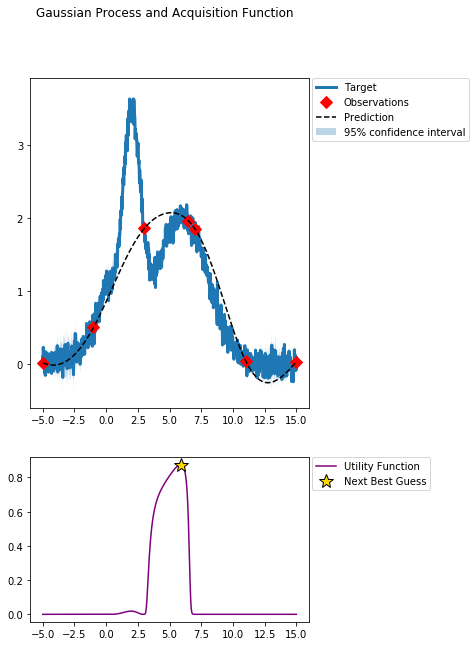

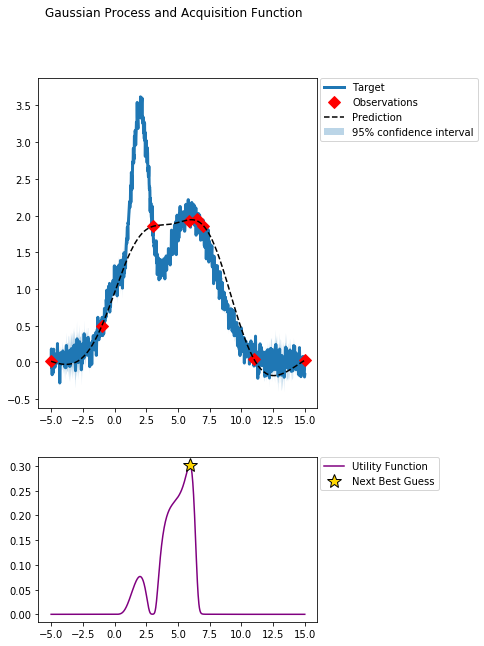

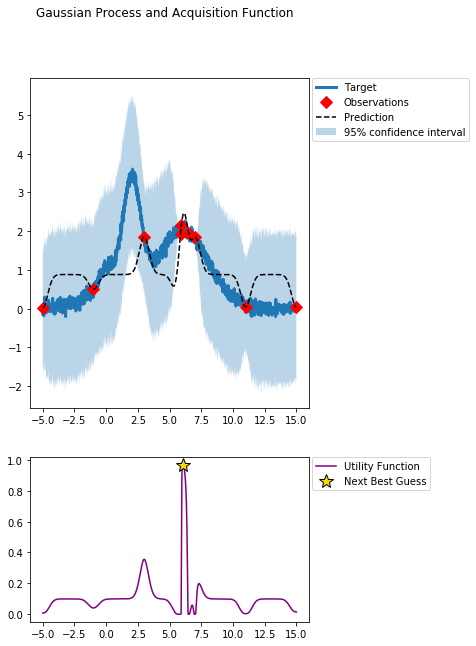

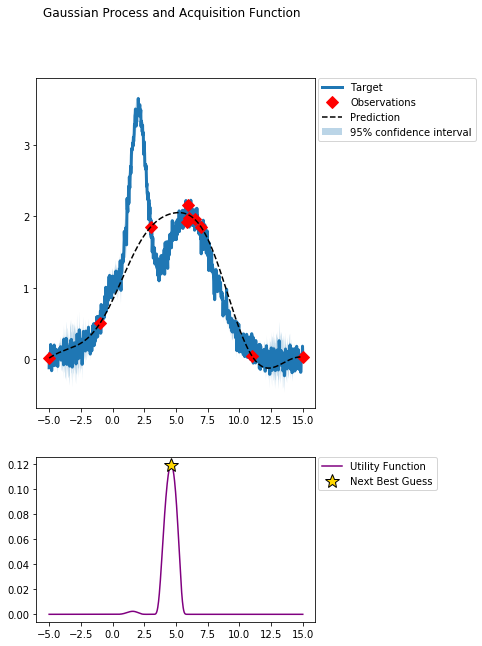

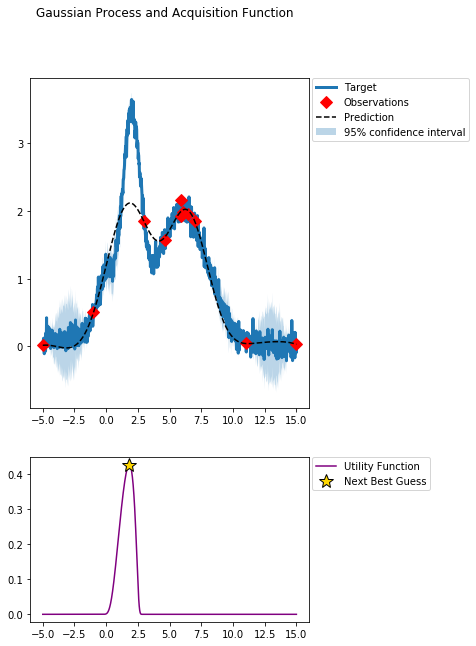

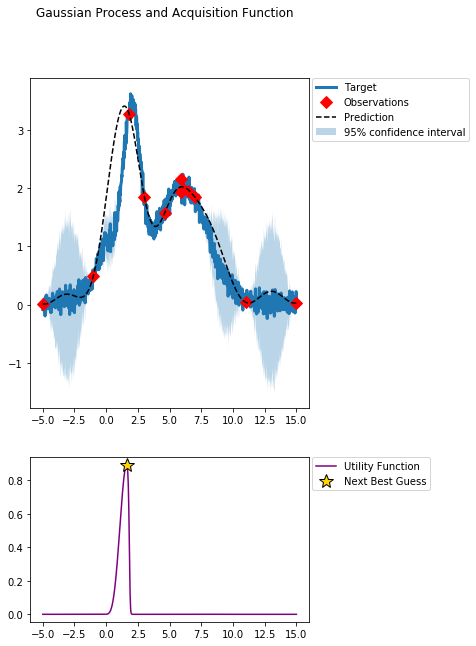

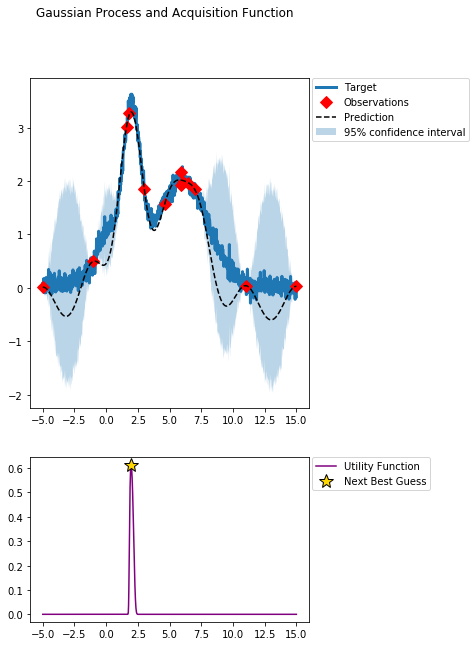

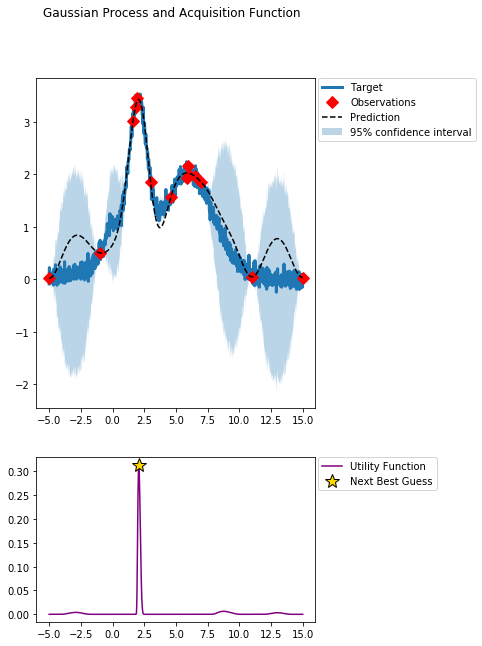

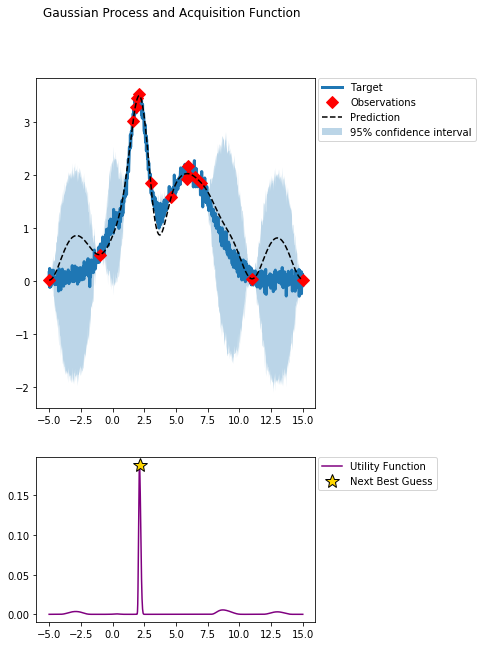

In [11]:
likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
model = ExactGPModel(train_x.data, train_y.data, likelihood)

iteration = 10
for i in range(iteration):
    # initialize likelihood and model
    #likelihood = GaussianLikelihood(log_noise_bounds=(-7, -6))
    model = ExactGPModel(train_x.data, train_y.data, likelihood)

    #train model
    train_model(model,train_x,train_y)
    model.eval()
    likelihood.eval()
    observed_pred = eval_model(model,likelihood)
    #choose acquisition function 

    #utility = mes.DiscreteMES(model,nK=100)
    utility = pi.DiscretePI(model)
    #utility = ei.DiscreteEI(model)
    #utility = ucb.DiscreteUCB(model, kappa=5)
    
    
    
    #acq,index = ucbi(observed_pred)
    #acq,index = eii(observed_pred,train_y)
    #acq,index = poi(observed_pred,train_y)
    #acq,index = mesi(observed_pred)

    acq, xx,_ = utility(x)

    
    #xx = Variable(x[index]).view(1)
    print("next point",xx)
    yy = func(xx.view(-1))
    plot_gp(train_x.numpy(), train_y.numpy(), x.numpy(), func(x).numpy(), observed_pred, True, acq, True)
    train_x = Variable(torch.cat((train_x,xx.view(-1))))
    train_y = Variable(torch.cat((train_y,yy)))    


In [12]:
torch.cuda.current_device()

3

In [13]:
a = torch.tensor([[1],[2]])
a.view(-1)

tensor([ 1,  2])